In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, load_fits, pycortex_plot_utils
from utils import roi_utils, default_paths
from analyze_fits import analyze_gabor_params

import copy

from feature_extraction import gabor_feature_extractor


#### Load model fits

In [32]:
subjects = np.arange(1,9)
# subjects=[1]
n_subjects = len(subjects)

fitting_type = 'gabor_solo_ridge_12ori_8sf'

out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) for ss in subjects]
fig_save_folder=None

# create non-overlapping ROIs
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

# make a list of voxels per subject
n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

# thresholding voxels based on their R2 for this model
r2_cutoff = 0.01
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

#### Get info about the Gabor feature space

In [5]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Do some analyses on the orientation/frequency selectivity profiles - find their peaks

In [15]:
feature_corr = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr.shape[0]
allcorr_reshaped = np.reshape(feature_corr, [n_voxels, n_ori, n_sf], order='F')

# first averaging over either orient or SF - then analyze "tuning curves" for other dimension.
mean_orient_corr = np.mean(allcorr_reshaped, axis=2)
mean_sf_corr = np.mean(allcorr_reshaped, axis=1)


n_ori_peaks, top_orients = analyze_gabor_params.analyze_orient_peaks(est_tuning_curves=mean_orient_corr, \
                                                                 val_r2 = val_r2, \
                                                                 r2_cutoff=0.01, peak_thresh=0.50,\
                                                                 ori_unique = ori_unique);

n_freq_peaks, top_freqs = analyze_gabor_params.analyze_freq_peaks(est_tuning_curves=mean_sf_corr, \
                                                                 val_r2 = val_r2, \
                                                                 r2_cutoff=0.01, peak_thresh=0.50,\
                                                                 sf_unique = sf_unique);

#### compute summary statistics for each ROI, each subject

how many voxels with each num peaks per roi, per subject?

In [16]:
n_ori_peaks_vals = np.arange(0,6)
roi_counts_n_ori_peaks = np.zeros((n_subjects, n_rois,len(n_ori_peaks_vals)),dtype=int)

for si in range(n_subjects):
    for ri in range(n_rois):
        inds = roi_def.get_indices(ri) & (subject_inds==si) & abv_thresh
        for pi, pp in enumerate(n_ori_peaks_vals):
            roi_counts_n_ori_peaks[si,ri,pi] = np.sum(n_ori_peaks[inds]==pp)

        assert(np.sum(roi_counts_n_ori_peaks[si,ri,:])==np.sum(inds))


#### make a bar plot of the number of peaks

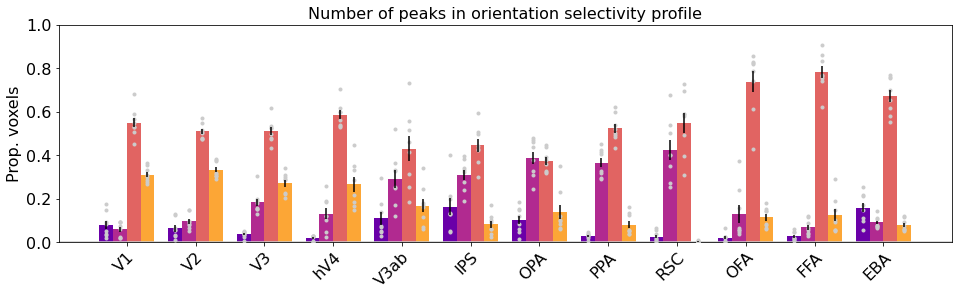

In [17]:
# combining anything >=3 into a single bar here

vals = copy.deepcopy(roi_counts_n_ori_peaks)
vals[:,:,3] = np.sum(vals[:,:,3:], axis=2)
vals = vals[:,:,0:4]

vals = vals/np.sum(vals, axis=2, keepdims=True) # convert to a proportion of total

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

labels = ['has %d peak'%pp for pp in n_ori_peaks_vals[0:4]]
labels[3] = 'has >=3 peaks'

colors = cm.plasma(np.linspace(0,1,6))[1:6,:]

plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(16)
fh = plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, \
                                space=0.1, \
                                point_data = vals, \
                xticklabels=roi_names, ylabel='Prop. voxels', \
                ylim=[0,1.0], title='Number of peaks in orientation selectivity profile', \
                horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(16,4), \
                colors=colors)

fn2save = os.path.join(default_paths.fig_path, 'Num_orient_peaks.pdf')
plt.savefig(fn2save)

#### Do some more analysis on the multi-peaked voxels

Separate them into groups w same peak locations

In [18]:
which_bimodal_group, top_bimodal_pairs, bimodal_pair_labels = \
        analyze_gabor_params.group_bimodal_voxels(n_ori_peaks, top_orients, n_groups_use=3)

which_trimodal_group, top_trimodal_pairs, trimodal_pair_labels = \
        analyze_gabor_params.group_trimodal_voxels(n_ori_peaks, top_orients, n_groups_use=3)

#### compute bimodal voxels summary statistics for each roi/subject

In [19]:
n_groups=4;
roi_counts_bimodal = np.zeros((n_subjects, n_rois, n_groups),dtype=int)
for si in range(n_subjects):
    for ri in range(n_rois):
        inds = roi_def.get_indices(ri) & (subject_inds==si) & abv_thresh & (n_ori_peaks==2)
        for pp in range(n_groups):
            roi_counts_bimodal[si,ri,pp] = np.sum(which_bimodal_group[inds]==pp)
            
        assert(np.sum(roi_counts_bimodal[si,ri,:])==np.sum(inds))


#### Make a barplot

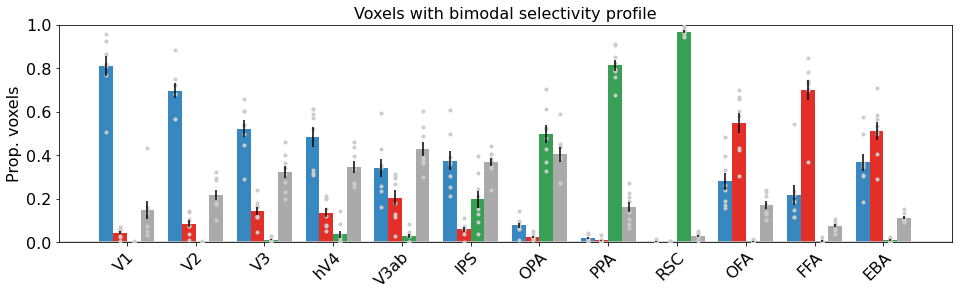

In [20]:
colors = np.concatenate([cm.Blues(np.linspace(0,1,4))[2:3,:],\
                         cm.Reds(np.linspace(0,1,4))[2:3,:],\
                         cm.Greens(np.linspace(0,1,4))[2:3,:],\
                         # cm.Purples(np.linspace(0,1,4))[2:3,:],\
                         cm.gray(np.linspace(0,1,4))[2:3,:]], axis=0)

vals = roi_counts_bimodal
vals = roi_counts_bimodal/np.sum(roi_counts_bimodal, axis=2, keepdims=True)

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

ylim = [0,1]
# ylim=[]

fh = plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, \
                                space=0.1, \
                                point_data=vals,\
                                xticklabels=roi_names, ylabel='Prop. voxels', \
                ylim=ylim, title='Voxels with bimodal selectivity profile', horizontal_line_pos=0,\
                legend_labels=bimodal_pair_labels, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(16,4), \
                colors=colors)

fn2save = os.path.join(default_paths.fig_path, 'Bimodal_groups.pdf')
plt.savefig(fn2save)

#### compute trimodal voxels summary statistics for each roi/subject

In [21]:
n_groups=4;
roi_counts_trimodal = np.zeros((n_subjects, n_rois, n_groups),dtype=int)
for si in range(n_subjects):
    for ri in range(n_rois):
        inds = roi_def.get_indices(ri) & (subject_inds==si) & abv_thresh & (n_ori_peaks==3)
        for pp in range(n_groups):
            roi_counts_trimodal[si,ri,pp] = np.sum(which_trimodal_group[inds]==pp)
            
        assert(np.sum(roi_counts_trimodal[si,ri,:])==np.sum(inds))


if any ROIs had zero tri-modal voxels for any subject, 
then skip them for the plot

In [24]:
rois_trimodal_use = ~np.any(np.sum(roi_counts_trimodal, axis=2)==0, axis=0)
[roi_names[rr] for rr in np.where(~rois_trimodal_use)[0]]

['RSC']

#### Make a barplot

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


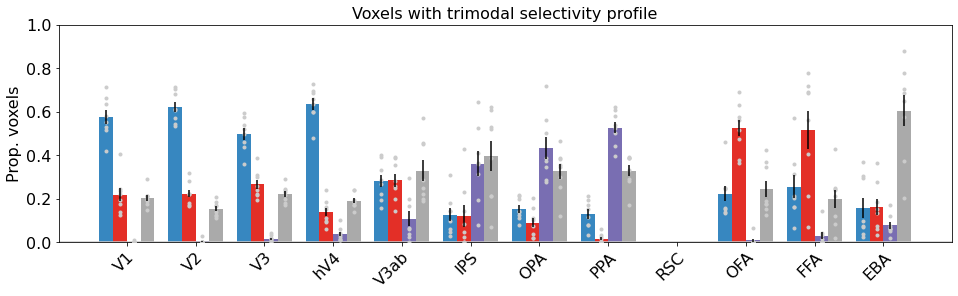

In [26]:
colors = np.concatenate([cm.Blues(np.linspace(0,1,4))[2:3,:],\
                         cm.Reds(np.linspace(0,1,4))[2:3,:],\
                         cm.Purples(np.linspace(0,1,4))[2:3,:],\
                         # cm.Oranges(np.linspace(0,1,4))[2:3,:],\
                         cm.gray(np.linspace(0,1,4))[2:3,:]], axis=0)

vals = copy.deepcopy(roi_counts_trimodal)
vals = roi_counts_trimodal/np.sum(roi_counts_trimodal, axis=2, keepdims=True)

vals[:,~rois_trimodal_use,:] = np.nan

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

fh = plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, \
                                space=0.1, \
                                point_data=vals, \
                xticklabels=roi_names, ylabel='Prop. voxels', \
                ylim=[0,1], title='Voxels with trimodal selectivity profile', horizontal_line_pos=0,\
                legend_labels=trimodal_pair_labels, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(16,4), \
                colors=colors)

fn2save = os.path.join(default_paths.fig_path,'Trimodal_groups.pdf')
plt.savefig(fn2save)

#### Same thing for frequency

here there are mostly uni-modal voxels

In [27]:
n_freq_peaks_vals = np.arange(0,4)
roi_counts_n_freq_peaks = np.zeros((n_subjects, n_rois,len(n_freq_peaks_vals)),dtype=int)

for si in range(n_subjects):
    for ri in range(n_rois):
        inds = roi_def.get_indices(ri) & (subject_inds==si) & abv_thresh
        for pi, pp in enumerate(n_freq_peaks_vals):
            roi_counts_n_freq_peaks[si,ri,pi] = np.sum(n_freq_peaks[inds]==pp)

        assert(np.sum(roi_counts_n_freq_peaks[si,ri,:])==np.sum(inds))


#### make a bar plot of the number of peaks

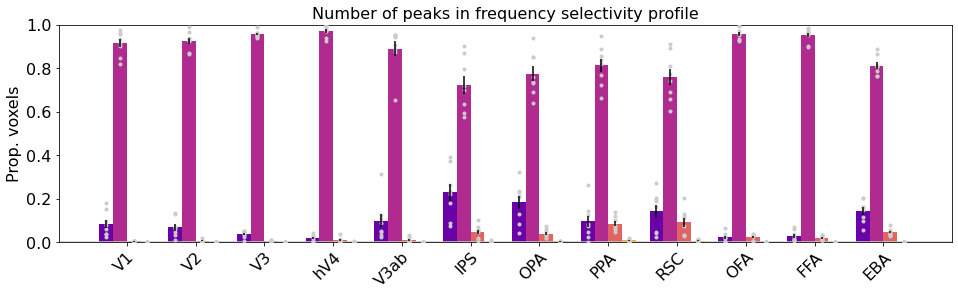

In [28]:
vals = roi_counts_n_freq_peaks

vals = vals/np.sum(vals, axis=2, keepdims=True) # convert to a proportion of total

meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

labels = ['has %d peak'%pp for pp in n_freq_peaks_vals]

colors = cm.plasma(np.linspace(0,1,6))[1:6,:]

plot_utils.set_all_font_sizes(16)
fh = plot_utils.plot_multi_bars(mean_data=meanvals, err_data=semvals, \
                                space=0.1, \
                                point_data=vals,\
                xticklabels=roi_names, ylabel='Prop. voxels', \
                ylim=[0,1], title='Number of peaks in frequency selectivity profile', \
                horizontal_line_pos=0,\
                legend_labels=labels, \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(16,4), \
                colors=colors)

fn2save = os.path.join(default_paths.fig_path, 'Num_spatfreq_peaks.pdf')
plt.savefig(fn2save)